In [1]:
# Files and modules
import pandas as pd, string, matplotlib.pyplot as plt
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

train = pd.read_csv("./disaster_response_messages_training.csv").drop(["split", "original", "id"], 1)
val = pd.read_csv("./disaster_response_messages_validation.csv").drop(["split", "original", "id"], 1)
test = pd.read_csv("./disaster_response_messages_test.csv").drop(["split", "original", "id"], 1)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
# Because the readme file told that the dataset contains binary target, we drop the "2" in related column
train = train[train["related"] != 2].reset_index(drop = True)
val = val[val["related"] != 2].reset_index(drop = True)
test = test[test["related"] != 2].reset_index(drop = True)

In [3]:
# Concatenating "train" and "val" data set as a single train dataframe
train = pd.concat([train, val]).reset_index(drop = True)

In [4]:
# Putting away message column, all columns are binary except genre column. Thus, we should encode this later
print("Columns types:\n")
for x in train.columns:
    print(f"- {x} : {train[x].dtypes}")

Columns types:

- message : object
- genre : object
- related : int64
- PII : int64
- request : int64
- offer : int64
- aid_related : int64
- medical_help : int64
- medical_products : int64
- search_and_rescue : int64
- security : int64
- military : int64
- child_alone : int64
- water : int64
- food : int64
- shelter : int64
- clothing : int64
- money : int64
- missing_people : int64
- refugees : int64
- death : int64
- other_aid : int64
- infrastructure_related : int64
- transport : int64
- buildings : int64
- electricity : int64
- tools : int64
- hospitals : int64
- shops : int64
- aid_centers : int64
- other_infrastructure : int64
- weather_related : int64
- floods : int64
- storm : int64
- fire : int64
- earthquake : int64
- cold : int64
- other_weather : int64
- direct_report : int64


In [5]:
# There're no missing values in train data set
print("Missing values in train data set:\n")
display(train.isna().sum())

Missing values in train data set:



message                   0
genre                     0
related                   0
PII                       0
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
child_alone               0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               0
other_infrastructure      0
weather_related           0
floods                    0
storm                     0
fire                      0
earthquake          

In [6]:
# Imbalanced class
display(train["related"].value_counts())

1    17720
0     5715
Name: related, dtype: int64

We focus on the positive class, which is tweets related to disaster because it's the main goal of classifying this data set. Hence, we won't handle this imbalanced data set by any way. Higher proportion of positive class enable the model to learn better in predicting positive class itself. I myself tried the prediction with over sampling technique and found the non - handled data set gained better score. 

Speaking about score, we will use recall score as our model's benchmark since false negative is far more important to be reduced. It would be dangerous if the machine fails to predict a real disaster - related tweet. The user would most likely fail to accommodate the impacted area or groups. On the other hand, if the machine falsely predict a non disaster - related tweet, it would costs nothing for the user. The only thing the user will sufer is time, because he will most likely confirm and check the truth of the disaster.

In [7]:
# Removing punctuation and encode "genre"
def prep(x):
    temp = []
    for m in x["message"]:
        for d in m:
            if d in list(string.punctuation):
                m = m.replace(d, " ")
        temp.append(m)
    
    x["message"] = temp
    
    x = pd.get_dummies(data = x, columns = ["genre"])
    
    return x

In [8]:
# Removing stop words, tokenizing, and converting text to token counts matrix
cvec = CountVectorizer(
    stop_words = "english",
    min_df = 50,
    lowercase = True
    )

# Pipelining the process
tfidf = TfidfTransformer()
textProcessor = ColumnTransformer([("message", Pipeline([
    ("vect", cvec),
    ("tfidf", tfidf)
    ]), "message")])

In [9]:
# Splitting
X, y = prep(train).drop("related", 1), train["related"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7, stratify = y)

In [11]:
# For plotting purpose
def plotConMat(name, model, trainX, testX, trainy, testy):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
  
    conMat = plot_confusion_matrix(model, trainX, trainy, cmap = "YlOrRd", values_format = "g", ax = ax[0])
    conMat.ax_.set_yticklabels(
      ("Not Related", "Related"),
      fontdict = {
          "verticalalignment": "center",
          "rotation" : 90
          }
        )
    ax[0].set_xticklabels(
      ("Not Related", "Related"),
      fontdict = {
          "horizontalalignment": "center",
          }
        )
    ax[0].set_xlabel(
      "Predicted Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    ax[0].set_ylabel(
      "True Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    conMat.ax_.set_title(
      name + " (Train)",
      fontdict = {
          "weight" : "bold",
          "size" : 14,
          "horizontalalignment" : "center"
          }, y = 1.05)

    conMat = plot_confusion_matrix(model, testX, testy, cmap = "YlOrRd", values_format = "g", ax = ax[1])
    conMat.ax_.set_yticklabels(
      ("Not Related", "Related"),
      fontdict = {
          "verticalalignment": "center",
          "rotation" : 90
          }
        )
    ax[1].set_xticklabels(
      ("Not Related", "Related"),
      fontdict = {
          "horizontalalignment": "center",
          }
        )
    ax[1].set_xlabel(
      "Predicted Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    ax[1].set_ylabel(
      "True Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    conMat.ax_.set_title(
      name + " (Test)",
      fontdict = {
          "weight" : "bold",
          "size" : 14,
          "horizontalalignment" : "center"
          }, y = 1.05)

    plt.tight_layout(pad = 8)
    plt.show()  

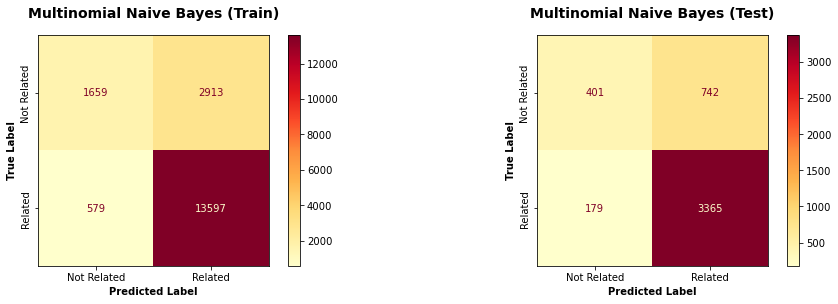


Positive recall score for validation data set :  0.9494920993227991


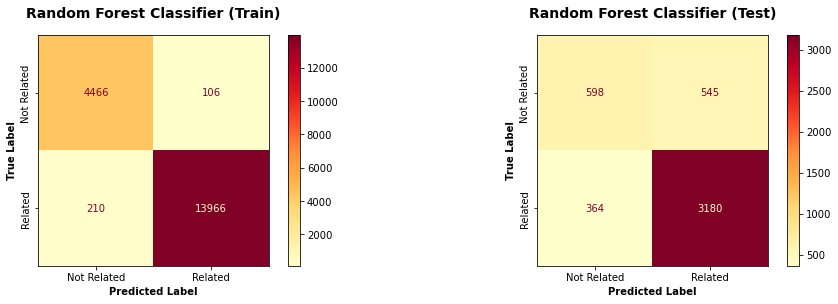


Positive recall score for validation data set :  0.8972911963882618


C:\Users\LENOVO\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


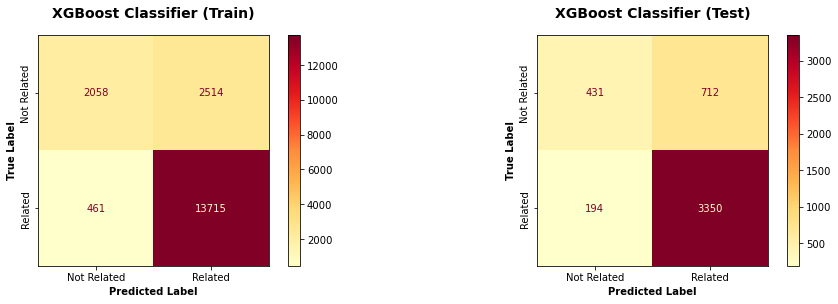


Positive recall score for validation data set :  0.9452595936794582


In [12]:
# Training and testing 3 algos and look for the best
# Multinomial Naive Bayes
NB_pipe = Pipeline([
    ("text", textProcessor),
    ("clf", MultinomialNB())
])

NB_pipe.fit(X_train, y_train)

pred = NB_pipe.predict(X_test)

plotConMat("Multinomial Naive Bayes", NB_pipe, X_train, X_test, y_train, y_test)

print("\nPositive recall score for validation data set : ", recall_score(y_test, pred))

# Random Forest Classifier
RF_pipe = Pipeline([
    ("text", textProcessor),
    ("clf", RandomForestClassifier())
])

RF_pipe.fit(X_train, y_train)

pred = RF_pipe.predict(X_test)

plotConMat("Random Forest Classifier", RF_pipe, X_train, X_test, y_train, y_test)

print("\nPositive recall score for validation data set : ", recall_score(y_test, pred))

# XGBoost Classifier
XGB_pipe = Pipeline([
    ("text", textProcessor),
    ("clf", XGBClassifier())
])

XGB_pipe.fit(X_train, y_train)

pred = XGB_pipe.predict(X_test)

plotConMat("XGBoost Classifier", XGB_pipe, X_train, X_test, y_train, y_test)

print("\nPositive recall score for validation data set : ", recall_score(y_test, pred))

Turns out Multinomial Naive Bayes got the best recall score. Therefore, we'll move to the test data set prediction with this model.

In [13]:
# Predicting test data set
X = prep(test).drop("related", 1)
pred = NB_pipe.predict(X)

print(f'''Prediction :

Non disaster tweets : {len(pred[pred == 0])} tweets
Disaster related tweets : {len(pred[pred == 1])} tweets''')

true = 0
for p, t in zip(pred, test["related"]):
    if p == t:
        true += 1
print(f"\nTrue predictions : {round((true / len(pred) * 100), 2)}%")

Prediction :

Non disaster tweets : 309 tweets
Disaster related tweets : 2311 tweets

True predictions : 85.84%
